In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# Parametry
IMG_HEIGHT = 64
IMG_WIDTH = 64
NUM_CLASSES = 3
BATCH_SIZE = 32
EPOCHS = 20

# Wczytanie danych z TFDS
# as_supervised=True -> zwróci tuple (obraz, etykieta)
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train[:80%]', 'train[80%:]', 'test'],  # podział 80/20 dla train/val
    shuffle_files=True,
    as_supervised=True,  # (image, label)
    with_info=True
)

# Funkcja do normalizacji obrazów
def normalize_img(image, label):
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Przygotowanie datasetów
train_ds = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = ds_val.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

# Buforowanie i batching
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Nazwy klas
class_names = ds_info.features['label'].names
print("Klasy:", class_names)

Klasy: ['rock', 'paper', 'scissors']


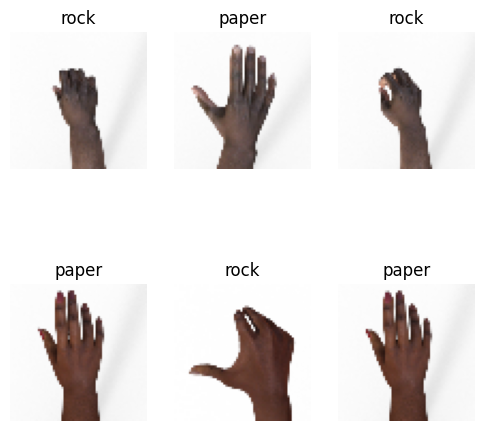

In [2]:
plt.figure(figsize=(6,6))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(2,3,i+1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [3]:
# Proste augmentacje dla poprawy generalizacji
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

# BUDOWANIE SIECI KONWOLUCYJNEJ (CNN)
def build_cnn_model():
    inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = data_augmentation(inputs)

    x = tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs, name="cnn_rps")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


model_complex = build_cnn_model()
model_complex.summary()

history = model_complex.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Model: "cnn_rps"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,385,187 (9.10 MB)

 Trainable params: 2,385,187 (9.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.3294 - loss: 1.1019 - val_accuracy: 0.4246 - val_loss: 1.0928
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.6047 - loss: 0.7984 - val_accuracy: 0.8611 - val_loss: 0.2918
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.8705 - loss: 0.3264 - val_accuracy: 0.9980 - val_loss: 0.0345
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.9400 - loss: 0.1796 - val_accuracy: 0.9960 - val_loss: 0.0151
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9658 - loss: 0.1074 - val_accuracy: 0.9980 - val_loss: 0.0107
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.9742 - loss: 0.0784 - val_accuracy: 1.0000 - val_loss: 0.0143
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.9683 - loss: 0.0871 - val_accuracy: 0.9960 - val_loss: 0.0227
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.9856 - loss: 0.0590 - val_accuracy: 1.0000 -

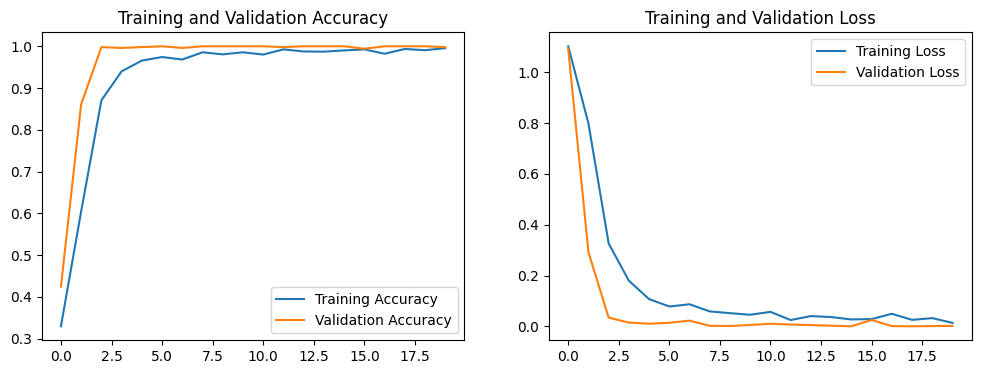

In [4]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")

plt.show()

In [5]:
test_loss, test_acc = model_complex.evaluate(test_ds)
print(f"Test accuracy:: {test_acc}")

model_complex.save("rps_complex_model.keras")
print("Model saved as rps_cnn_model.keras")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9597 - loss: 0.0859
Test accuracy:: 0.9596773982048035
Model saved as rps_cnn_model.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


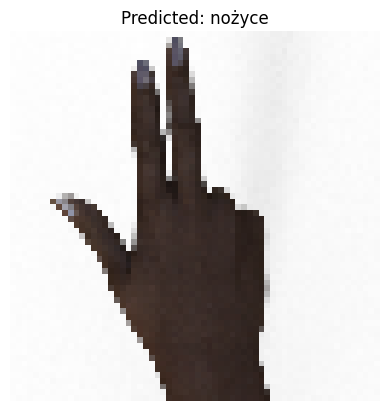

papier: 0.0000
kamień: 0.0000
nożyce: 1.0000


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def predict_and_show(img_path, model, class_names):
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # dodaj wymiar batch

    img_array_norm = img_array / 255.0

    predictions = model.predict(img_array_norm)
    predicted_class = np.argmax(predictions, axis=1)[0]

    plt.imshow(np.uint8(img_array[0]))
    plt.axis('off')
    plt.title(f"Predicted: {class_names[predicted_class]}")
    plt.show()

    for i, prob in enumerate(predictions[0]):
        print(f"{class_names[i]}: {prob:.4f}")

class_names = ["papier", "kamień", "nożyce"]
imgpath2 = Path("data/rps-test-set/scissors/scissors9.png")
predict_and_show(imgpath2, model_complex, class_names)

